# **0. 프로젝트 개요**
■ 목표 및 기대효과

 행동 예측

 : 상담 이력과 특성 정보를 바탕으로 특정 고객의 재상담률을 예측하고, 품목명별 해당하는 사건 제목과 상담 이유를 살펴보고, 재상담을 방지합니다.

■ 알고리즘 : XGBoost 모델

# 1.**데이터 불러오기 및 병합하기**

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')
file_path1 = "/content/drive/MyDrive/Colab Notebooks/공정거래위원회_상담/공정거래위원회_소비자 민원학습데이터 소비자상담 접수내역_20201231.csv"
file_path2 = "/content/drive/MyDrive/Colab Notebooks/공정거래위원회_상담/공정거래위원회_소비자 민원학습데이터 소비자상담 신청인 특성정보_20210131.csv"
df1 = pd.read_csv(file_path1,encoding='cp949')
df2 = pd.read_csv(file_path2,encoding='cp949')
merged_df = pd.merge(df1, df2, on='사건번호(ACCIDENT_NO)', how='inner')
print(merged_df.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['사건번호(ACCIDENT_NO)', '접수일자(RCPT_YMD)_x', '성별코드(GENDER_CODE)_x',
       '성별(GENDER)_x', '연령대코드(AGE_GROUP_CODE)_x', '연령대명(AGE_GROUP_NAME)_x',
       '지역코드(AREA_CODE)_x', '지역명(AREA_NAME)_x', '품목코드(ITEM_CODE)',
       '품목명(ITEM_NAME)', '사건제목(ACCIDENT_TITLE)', '상담이유코드(DSCSN_REASON_CODE)',
       '상담이유명(DSCSN_REASON_NAME)', '접수일자(RCPT_YMD)_y', '성별코드(GENDER_CODE)_y',
       '성별(GENDER)_y', '연령대코드(AGE_GROUP_CODE)_y', '연령대명(AGE_GROUP_NAME)_y',
       '지역코드(AREA_CODE)_y', '지역명(AREA_NAME)_y'],
      dtype='object')


# **2. 시각화를 위한 한글 폰트 설치**

In [2]:
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
# matplotlib의 한글 폰트 캐시를 삭제
!rm -rf ~/.cache/matplotlib/

# **3. EDA 및 전처리 & 정제**

##들어가기 ) EDA 확인 사항

1. 기본 정보 확인
 데이터의 크기, 열의 이름, 데이터 타입을 확인합니다.
2.결측치 확인
 어떤 열에 결측치가 있는지, 그 양이 얼마나 되는지 확인합니다.
3.기술통계 확인
 연속형 변수의 경우 평균, 중앙값, 표준편차, 최대값, 최소값 등의 기술통계를 확인합니다.
4.데이터 분포 확인
 히스토그램, 박스 플롯 등을 사용하여 데이터의 분포를 시각화합니다.
5.범주형 변수의 빈도 확인
 각 범주의 빈도나 백분율을 확인합니다.
6.상관 관계 확인
 연속형 변수 간의 상관 관계를 확인합니다.
7. 기타 시각화
 데이터에 따라 바 차트, 산점도, 히트맵 등 다양한 시각화를 수행합니다.

# 들어가기 ) 전처리와 정제 시 확인 사항

결측치 처리: 데이터에 결측치가 있는 경우, 해당 결측치를 적절한 방법으로 처리해야 합니다. 결측치를 채우거나 삭제하는 등의 방법을 사용합니다.

중복 데이터 처리: 중복된 데이터를 제거하거나 중복을 식별할 수 있는 특정 컬럼을 사용하여 중복 데이터를 처리합니다.

불필요한 컬럼 삭제: 분석에 불필요한 컬럼은 삭제하고, 필요한 컬럼만 남깁니다.

데이터 형식 변환: 날짜와 같은 데이터 형식을 적절하게 변환합니다.

범주형 데이터 처리: 범주형 데이터는 머신러닝 모델에서 사용하기 위해 원-핫 인코딩 또는 레이블 인코딩과 같은 방법으로 처리합니다.

새로운 피처 생성: 필요한 경우 기존 피처를 사용하여 새로운 피처를 생성합니다.

데이터 분할: 데이터를 학습용(train)과 평가용(test) 데이터로 분할합니다.

스케일링 또는 정규화: 모델의 성능을 향상시키기 위해 수치형 데이터를 스케일링 또는 정규화합니다.

데이터 탐색(EDA): 데이터의 분포를 시각화하고 통계적 요약을 통해 데이터를 더 잘 이해합니다.

모델 선택: 분석 목표에 따라 적절한 머신러닝 모델을 선택합니다.



In [3]:
#기본 정보 확인
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44563 entries, 0 to 44562
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   사건번호(ACCIDENT_NO)          44563 non-null  object 
 1   접수일자(RCPT_YMD)_x           44563 non-null  object 
 2   성별코드(GENDER_CODE)_x        43215 non-null  float64
 3   성별(GENDER)_x               43215 non-null  object 
 4   연령대코드(AGE_GROUP_CODE)_x    44563 non-null  float64
 5   연령대명(AGE_GROUP_NAME)_x     44563 non-null  object 
 6   지역코드(AREA_CODE)_x          44563 non-null  int64  
 7   지역명(AREA_NAME)_x           44563 non-null  object 
 8   품목코드(ITEM_CODE)            44563 non-null  int64  
 9   품목명(ITEM_NAME)             44537 non-null  object 
 10  사건제목(ACCIDENT_TITLE)       44563 non-null  object 
 11  상담이유코드(DSCSN_REASON_CODE)  44563 non-null  int64  
 12  상담이유명(DSCSN_REASON_NAME)   44563 non-null  object 
 13  접수일자(RCPT_YMD)_y           44563 non-null  obj

# **3.2. 결측치 확인 및 제거, 그리고 기술 통계**

각 변수에서 결측치의 비율이나 개수 확인 결측치 발생 원인 파악 및 결측치 처리 전략 수립


의견 )기본정보와 결측치의 전체적인 해석
□ 기본 정보: 데이터는 총 499,999개의 행과 25개의 열로 구성되어 있습니다. 각 컬럼은 다양한 데이터 타입을 가지고 있으며, 주로 object, float64 및 int64 타입입니다. 특히 _x와 _y로 끝나는 동일한 이름의 컬럼이 있어, 중복된 데이터일 가능성이 높습니다.

□ 결측치: 성별코드(GENDER_CODE)_x & 성별(GENDER)_x & 성별코드(GENDER_CODE)_y & 성별(GENDER)_y:

각각 3305개의 결측치를 가지고 있습니다. 성별 정보가 누락된 사건들이 있는 것으로 보입니다. 연령대코드(AGE_GROUP_CODE)_x & 연령대명(AGE_GROUP_NAME)_x & 연령대코드(AGE_GROUP_CODE)_y & 연령대명(AGE_GROUP_NAME)_y:

각각 433개의 결측치를 가지고 있습니다. 연령대 정보가 누락된 사건들이 있는 것으로 판단됩니다. 품목명(ITEM_NAME)_x & 품목명(ITEM_NAME)_y:

각각 295개의 결측치를 가지고 있습니다. 품목명 정보가 누락된 사건들이 있는 것으로 보입니다. 나머지 컬럼들은 결측치가 없습니다.

□종합적인 해석 데이터에는 중복되어 보이는 컬럼이 있습니다. _x와 _y로 끝나는 컬럼은 같은 정보를 가진 것으로 보이므로 분석 시 중복을 고려하여 처리해야 할 것 같습니다.

성별, 연령대, 품목명 관련 컬럼에서 결측치가 발견되었습니다. 이러한 결측치는 데이터 수집 과정에서의 오류나 특정 정보가 입력되지 않은 경우에 발생할 수 있습니다.

결측치 처리 전략을 세워야 합니다. 예를 들어, 결측치를 포함하는 행을 제거하거나 특정 값으로 채워 넣을 수 있습니다. 처리 방식은 분석 목적과 데이터의 특성에 따라 달라질 수 있습니다.

In [4]:
print(merged_df.isnull().sum())

사건번호(ACCIDENT_NO)               0
접수일자(RCPT_YMD)_x                0
성별코드(GENDER_CODE)_x          1348
성별(GENDER)_x                 1348
연령대코드(AGE_GROUP_CODE)_x         0
연령대명(AGE_GROUP_NAME)_x          0
지역코드(AREA_CODE)_x               0
지역명(AREA_NAME)_x                0
품목코드(ITEM_CODE)                 0
품목명(ITEM_NAME)                 26
사건제목(ACCIDENT_TITLE)            0
상담이유코드(DSCSN_REASON_CODE)       0
상담이유명(DSCSN_REASON_NAME)        0
접수일자(RCPT_YMD)_y                0
성별코드(GENDER_CODE)_y          1348
성별(GENDER)_y                 1348
연령대코드(AGE_GROUP_CODE)_y         0
연령대명(AGE_GROUP_NAME)_y          0
지역코드(AREA_CODE)_y               0
지역명(AREA_NAME)_y                0
dtype: int64


# **3.2.1. 성별코드**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


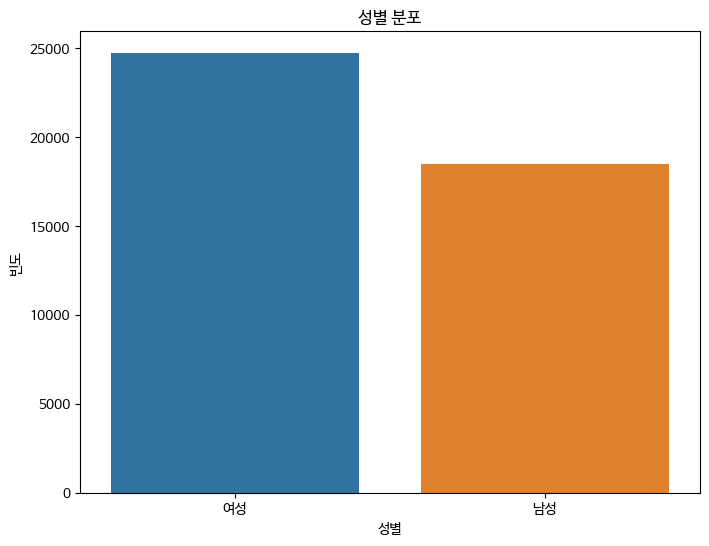

In [5]:
# 성별코드에 대한 결측치 제거
cleaned_df = merged_df.dropna(subset=['성별코드(GENDER_CODE)_x'])

# 성별 분포 확인
plt.figure(figsize=(8, 6))
sns.countplot(data=cleaned_df, x='성별(GENDER)_x')
plt.title('성별 분포')
plt.xlabel('성별')  #설명) 여자와 남자
plt.ylabel('빈도')  #설명) 여자와 남자의 빈도
plt.show()

# **3.2.2. 연령 및 성별 분포**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


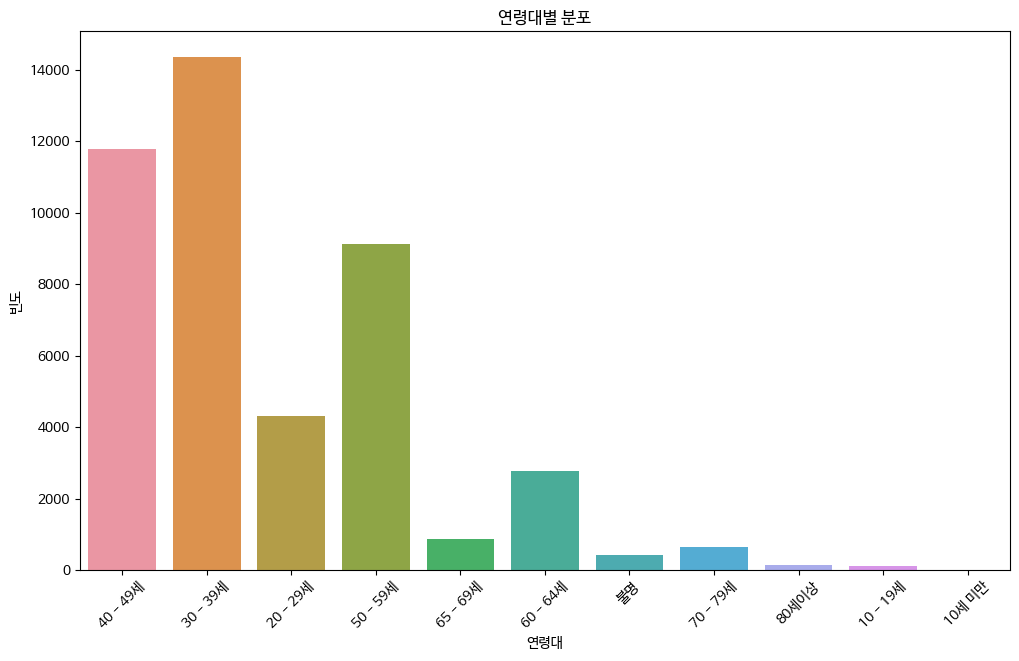

In [6]:
# 연령별 코드에 대한 결측치 제거
cleaned_df = merged_df.dropna(subset=['연령대코드(AGE_GROUP_CODE)_x'])

# 연령대별 분포 확인
plt.figure(figsize=(12, 7))
sns.countplot(data=cleaned_df, x='연령대명(AGE_GROUP_NAME)_x')
plt.title('연령대별 분포')
plt.xlabel('연령대')  # 설명) 연령대
plt.ylabel('빈도')  # 설명) 각 연령대별 빈도
plt.xticks(rotation=45)
plt.show()

       성별코드(GENDER_CODE)_x  연령대코드(AGE_GROUP_CODE)_x  지역코드(AREA_CODE)_x  \
count         43215.000000             44563.000000       44563.000000   
mean              1.572371                 5.285730         775.826022   
std               0.494740                 2.099489         609.676817   
min               1.000000                 1.000000         100.000000   
25%               1.000000                 4.000000         401.000000   
50%               2.000000                 5.000000         800.000000   
75%               2.000000                 6.000000        1107.000000   
max               2.000000                12.000000        9907.000000   

       품목코드(ITEM_CODE)  상담이유코드(DSCSN_REASON_CODE)  성별코드(GENDER_CODE)_y  \
count     44563.000000               44563.000000         43215.000000   
mean     278896.418217                 609.426295             1.572371   
std      121037.549850                   3.402342             0.494740   
min      110101.000000               

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


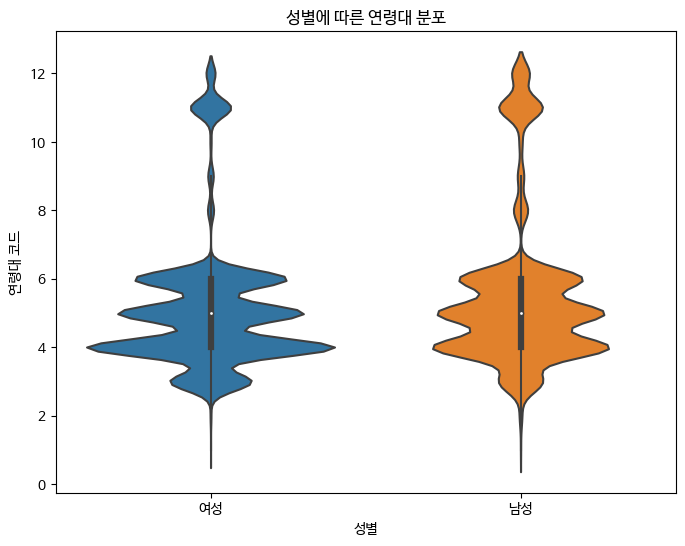

In [7]:
#3.2.2. 연령 맟 성별 분포 : 기술 통계 확인 및 시각화
import seaborn as sns

# 기초 통계량 확인
print(cleaned_df.describe())

# 성별에 따른 연령대의 분포를 violinplot으로 시각화
plt.figure(figsize=(8, 6))
sns.violinplot(data=cleaned_df, x='성별(GENDER)_x', y='연령대코드(AGE_GROUP_CODE)_x')
plt.title('성별에 따른 연령대 분포')
plt.xlabel('성별')
plt.ylabel('연령대 코드')
plt.show()

# **3.2.3. 지역 코드**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


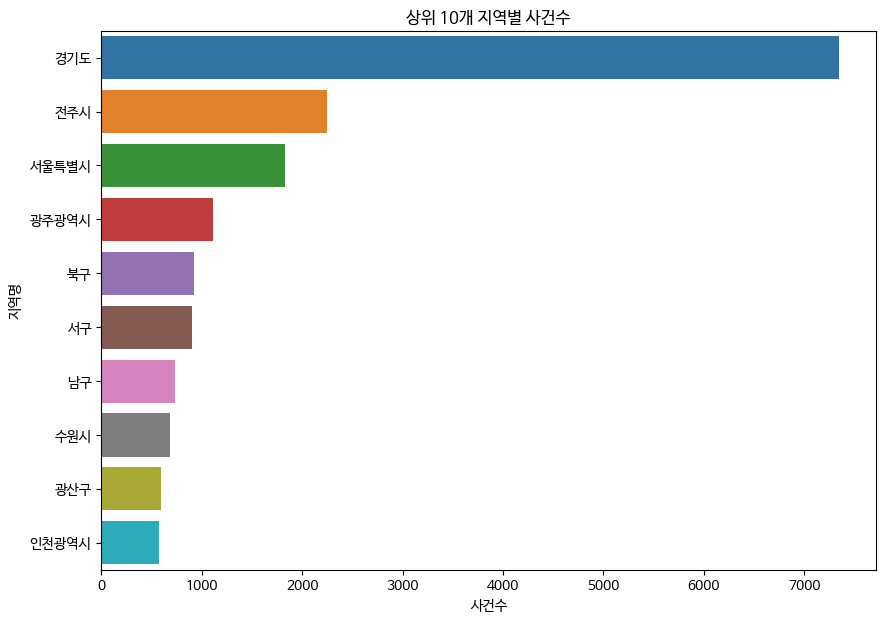

In [8]:
#3.2.3. 지역 코드 : 결측치 제거 및 시각화
# 지역 코드에 대한 결측치 제거
cleaned_df = merged_df.dropna(subset=['지역코드(AREA_CODE)_x'])
# 상위 10개 지역만 선택
top_10_areas = cleaned_df['지역명(AREA_NAME)_x'].value_counts().head(10).index

# 필터링된 데이터프레임 생성
filtered_df = cleaned_df[cleaned_df['지역명(AREA_NAME)_x'].isin(top_10_areas)]

# 시각화
plt.figure(figsize=(10, 7))
sns.countplot(data=filtered_df, y='지역명(AREA_NAME)_x', order=top_10_areas)
plt.title('상위 10개 지역별 사건수')
plt.xlabel('사건수')
plt.ylabel('지역명')
plt.show()

# **3.2.4. 품목명**

In [9]:
print(merged_df.columns)   #중간 컬럼 재확인

Index(['사건번호(ACCIDENT_NO)', '접수일자(RCPT_YMD)_x', '성별코드(GENDER_CODE)_x',
       '성별(GENDER)_x', '연령대코드(AGE_GROUP_CODE)_x', '연령대명(AGE_GROUP_NAME)_x',
       '지역코드(AREA_CODE)_x', '지역명(AREA_NAME)_x', '품목코드(ITEM_CODE)',
       '품목명(ITEM_NAME)', '사건제목(ACCIDENT_TITLE)', '상담이유코드(DSCSN_REASON_CODE)',
       '상담이유명(DSCSN_REASON_NAME)', '접수일자(RCPT_YMD)_y', '성별코드(GENDER_CODE)_y',
       '성별(GENDER)_y', '연령대코드(AGE_GROUP_CODE)_y', '연령대명(AGE_GROUP_NAME)_y',
       '지역코드(AREA_CODE)_y', '지역명(AREA_NAME)_y'],
      dtype='object')


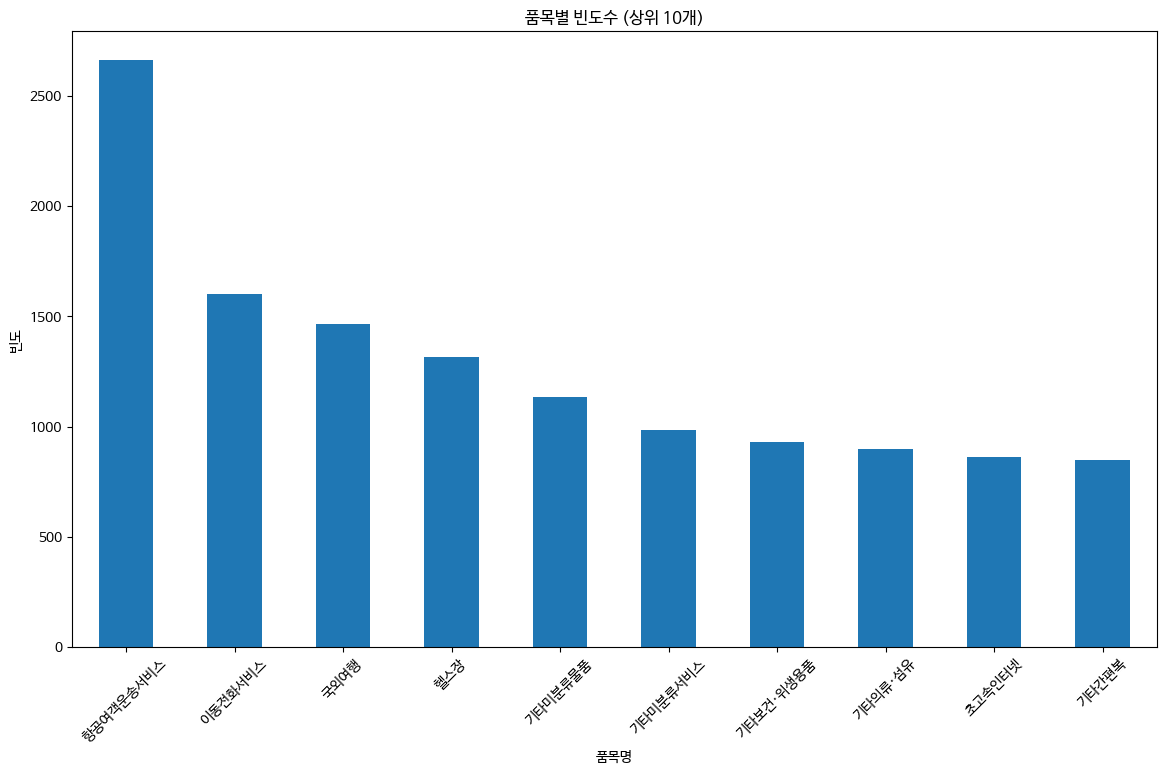

In [10]:
# 결측치 처리
cleaned_df = merged_df.dropna(subset=['품목명(ITEM_NAME)'])

#품목명별 분포 확인 (상위 10개)
top10 = cleaned_df['품목명(ITEM_NAME)'].value_counts().head(10)

plt.figure(figsize=(14, 8))
top10.plot(kind='bar')
plt.title('품목별 빈도수 (상위 10개)')
plt.xlabel('품목명')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

# **3.2.5. 품목명별 해당하는 사건 제목은(고객 상담 접수 제목)?**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-11-b165fb02188e>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


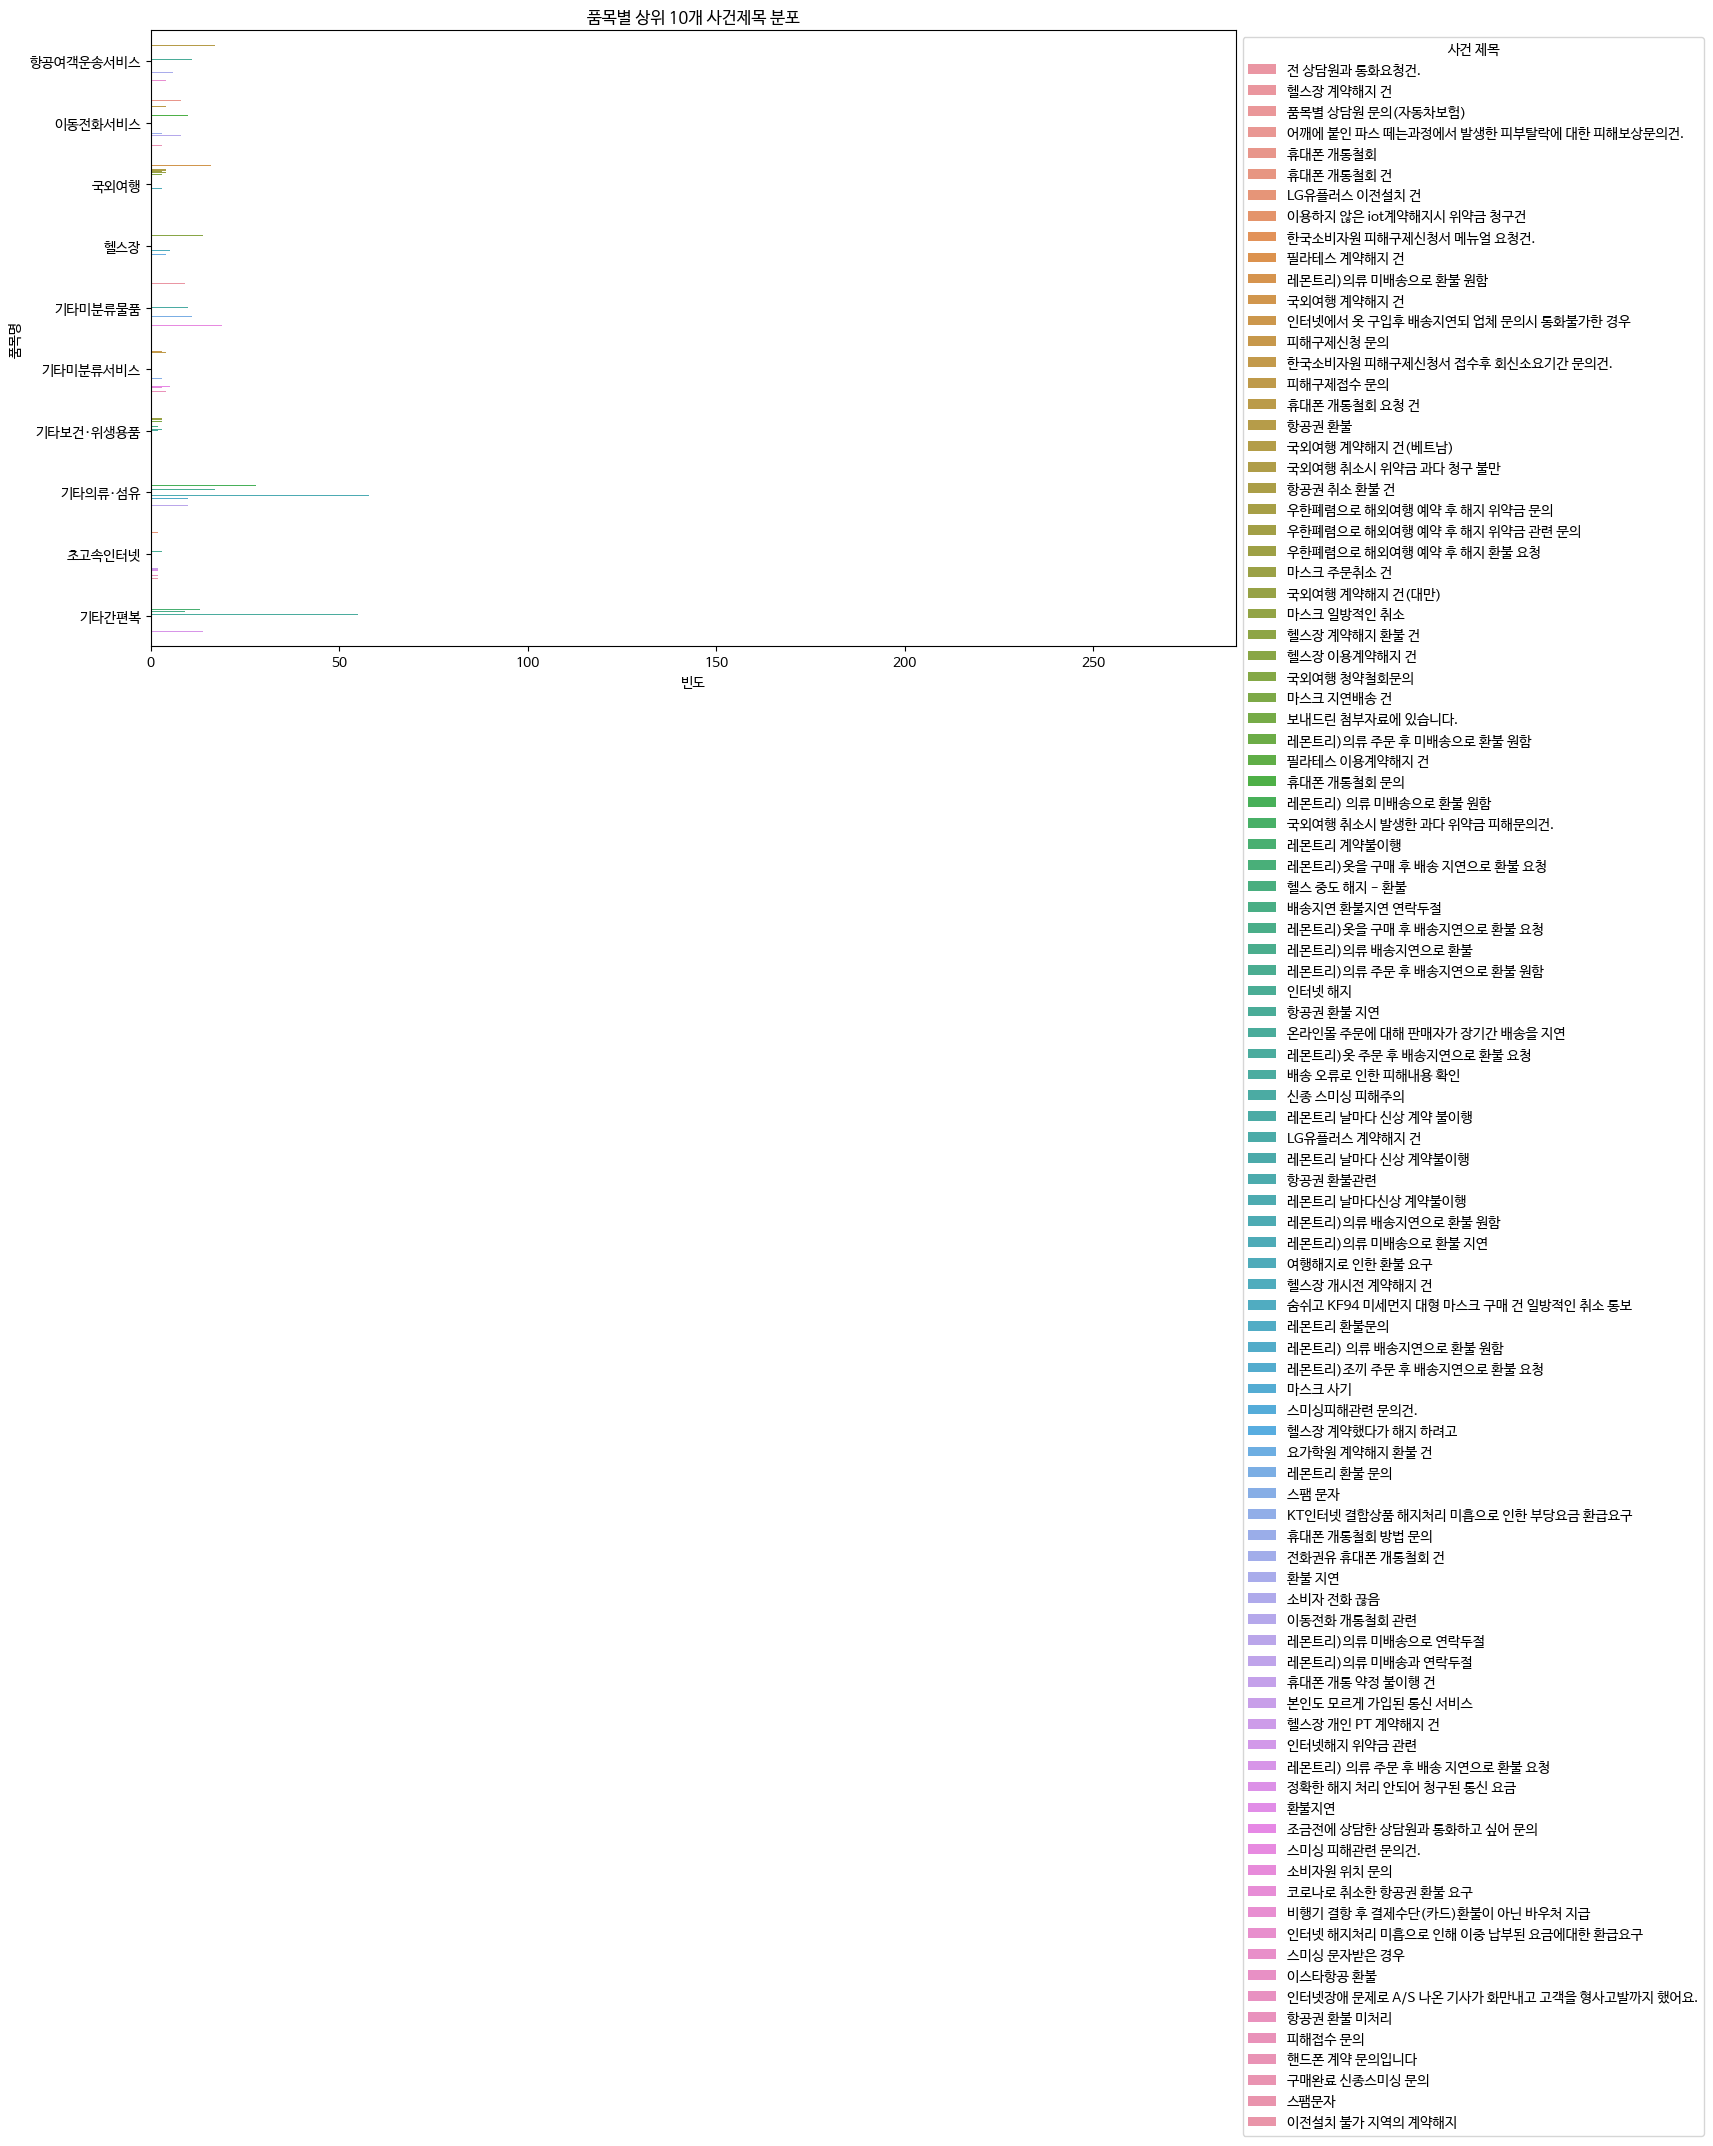

In [11]:
# 상위 10개 품목명 추출
top10_items = cleaned_df['품목명(ITEM_NAME)'].value_counts().head(10).index.tolist()

# 품목별 상위 5개 사건제목 필터링
top_titles_per_item = cleaned_df[cleaned_df['품목명(ITEM_NAME)'].isin(top10_items)].groupby('품목명(ITEM_NAME)')['사건제목(ACCIDENT_TITLE)'].value_counts().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='count')

# 필터링된 데이터프레임 생성
filtered_df = cleaned_df.merge(top_titles_per_item, on=['품목명(ITEM_NAME)', '사건제목(ACCIDENT_TITLE)'])

# 시각화
plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_df, y='품목명(ITEM_NAME)', hue='사건제목(ACCIDENT_TITLE)', order=top10_items)
plt.title('품목별 상위 10개 사건제목 분포')
plt.xlabel('빈도')
plt.ylabel('품목명')
plt.legend(title='사건 제목', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **3.2.6. 사건 제목별 상담 이유와 빈도는?**

---



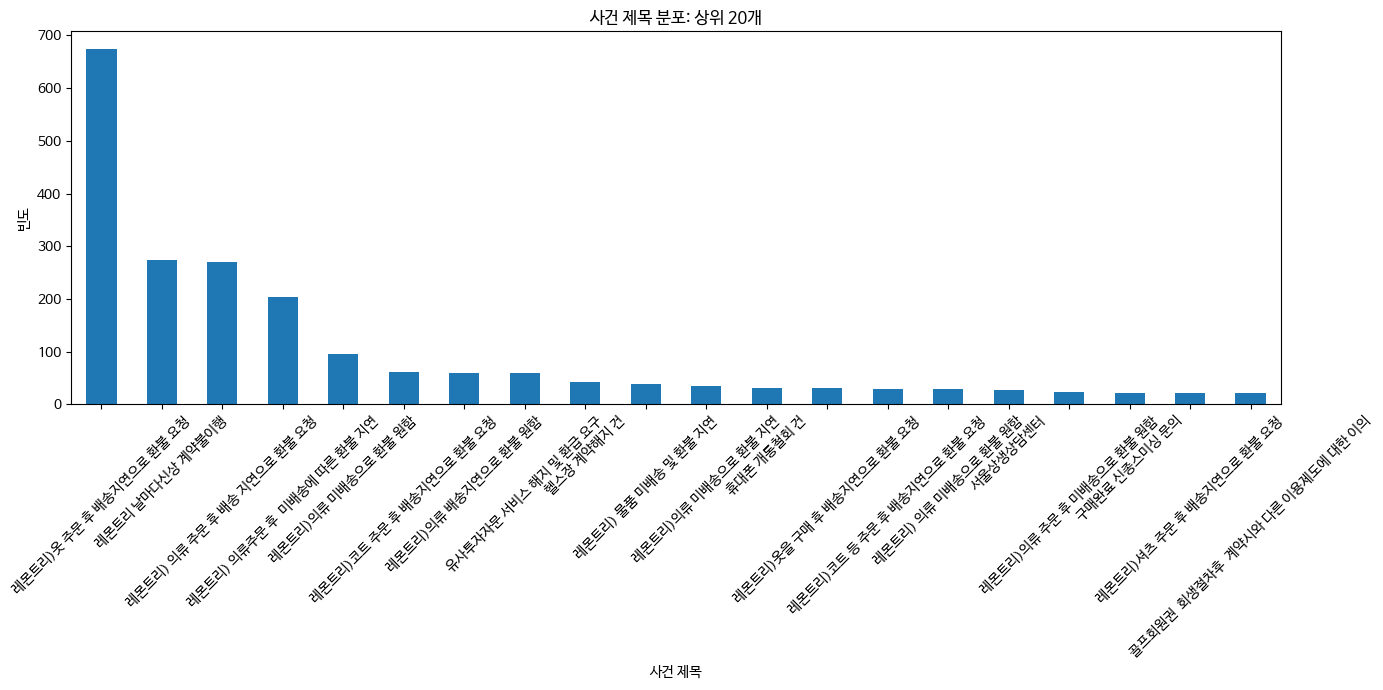

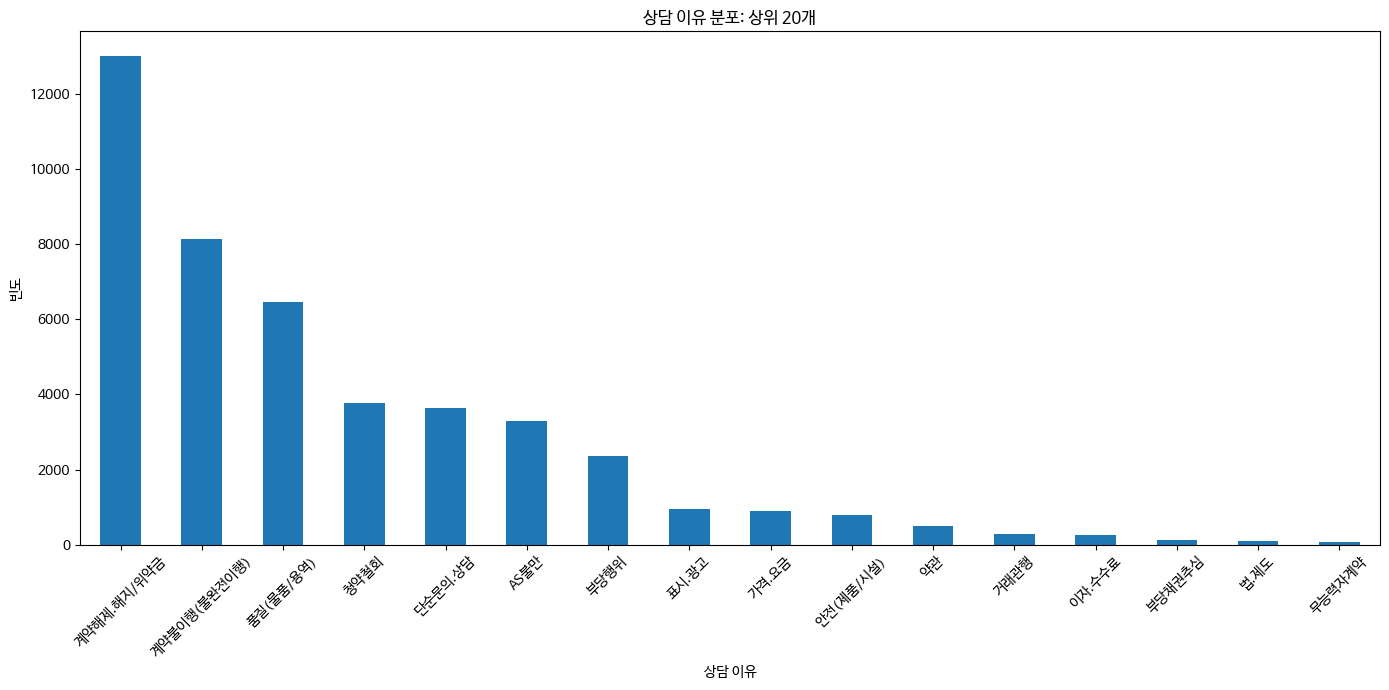

In [12]:
cleaned_df = merged_df.dropna(subset=['사건제목(ACCIDENT_TITLE)', '상담이유명(DSCSN_REASON_NAME)', '접수일자(RCPT_YMD)_y'])
plt.figure(figsize=(14, 7))
cleaned_df['사건제목(ACCIDENT_TITLE)'].value_counts().head(20).plot(kind='bar')
plt.title('사건 제목 분포: 상위 20개')
plt.xlabel('사건 제목')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
cleaned_df['상담이유명(DSCSN_REASON_NAME)'].value_counts().head(20).plot(kind='bar')
plt.title('상담 이유 분포: 상위 20개')
plt.xlabel('상담 이유')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **3.2.7. 전체적인 접수 일자**

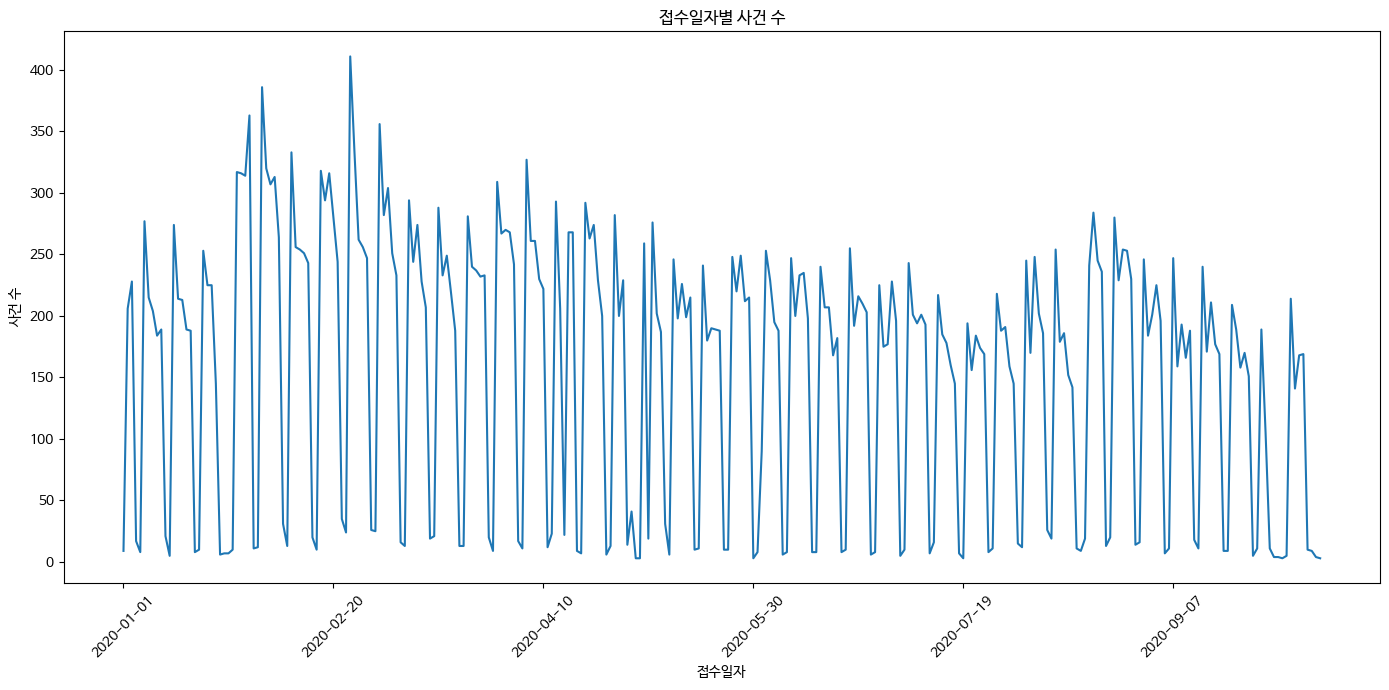

In [13]:
#전체적인 접수 일자별 사건 수
plt.figure(figsize=(14, 7))
cleaned_df['접수일자(RCPT_YMD)_y'].value_counts().sort_index().plot(kind='line')
plt.title('접수일자별 사건 수')
plt.xlabel('접수일자')
plt.ylabel('사건 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **3.2.8. 접수된 사건 제목별 상담 이유는 토픽별 무엇인가?**

사건제목(ACCIDENT_TITLE) 기술통계:
count                        44563
unique                       40044
top       레몬트리)옷 주문 후 배송지연으로 환불 요청
freq                           674
Name: 사건제목(ACCIDENT_TITLE), dtype: object


상담이유명(DSCSN_REASON_NAME) 기술통계:
count           44563
unique             16
top       계약해제.해지/위약금
freq            13010
Name: 상담이유명(DSCSN_REASON_NAME), dtype: object


접수일자(RCPT_YMD)_y 기술통계:
count          44563
unique           286
top       2020-02-24
freq             411
Name: 접수일자(RCPT_YMD)_y, dtype: object


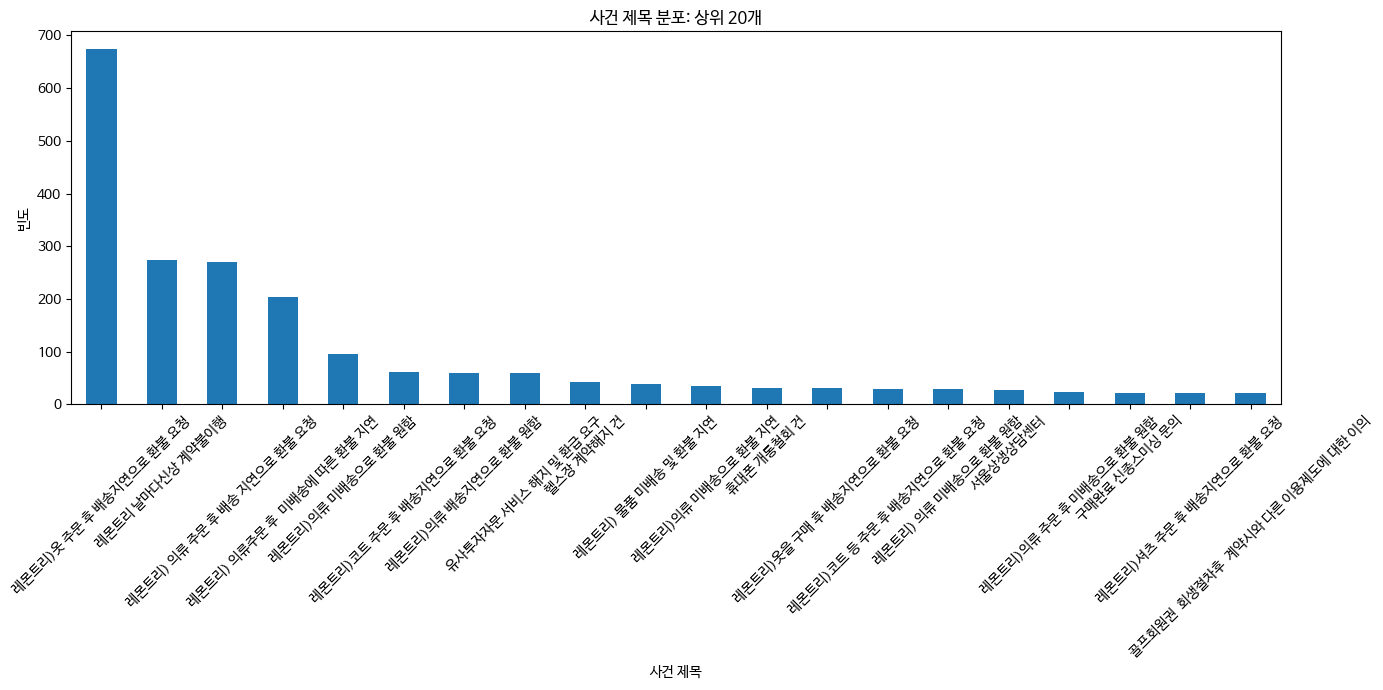

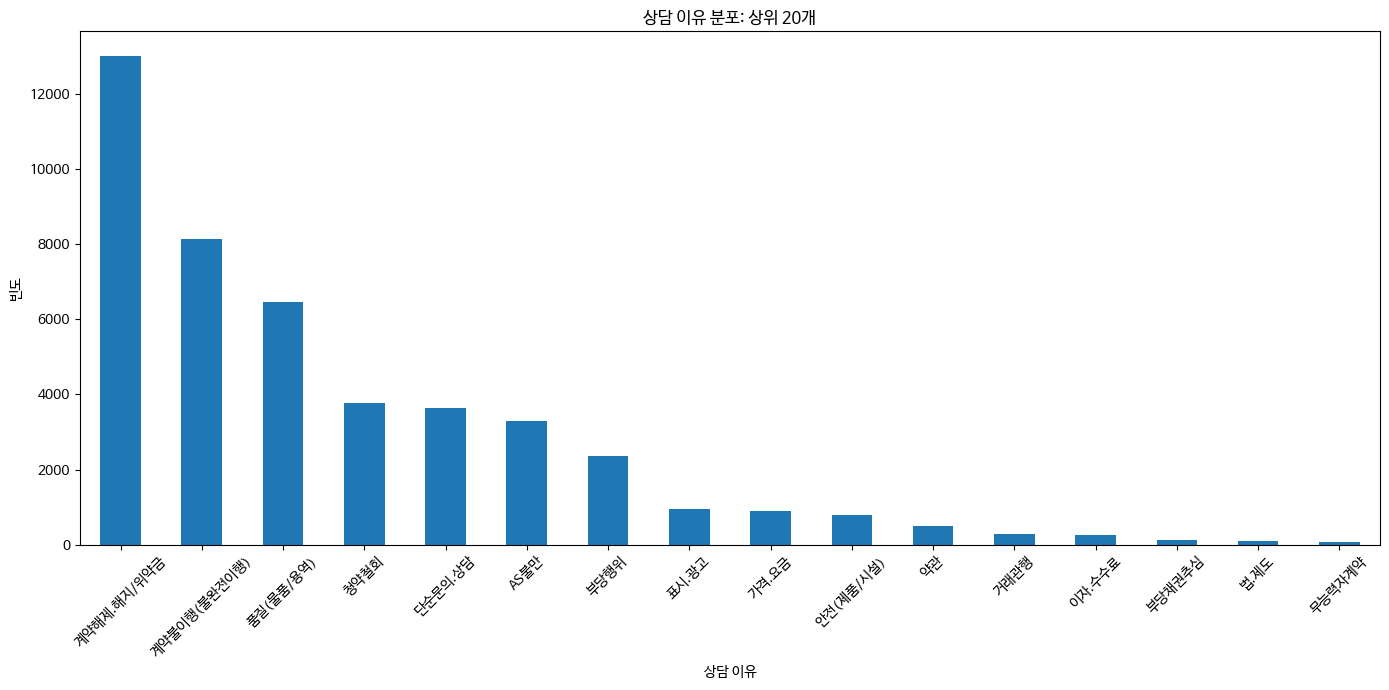

In [14]:
#기술통계
print("사건제목(ACCIDENT_TITLE) 기술통계:")
print(cleaned_df['사건제목(ACCIDENT_TITLE)'].describe())
print("\n")

print("상담이유명(DSCSN_REASON_NAME) 기술통계:")
print(cleaned_df['상담이유명(DSCSN_REASON_NAME)'].describe())
print("\n")

print("접수일자(RCPT_YMD)_y 기술통계:")
print(cleaned_df['접수일자(RCPT_YMD)_y'].describe())
#기술통계시각화
plt.figure(figsize=(14, 7))
cleaned_df['사건제목(ACCIDENT_TITLE)'].value_counts().head(20).plot(kind='bar')
plt.title('사건 제목 분포: 상위 20개')
plt.xlabel('사건 제목')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
cleaned_df['상담이유명(DSCSN_REASON_NAME)'].value_counts().head(20).plot(kind='bar')
plt.title('상담 이유 분포: 상위 20개')
plt.xlabel('상담 이유')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **3.2.9. 레몬트리를 포함한 토픽별 주요 단어는?**

토픽 1: 불완전이행, 계약불이행, 청약철회, 용역, 품질
토픽 2: 계약해제, 위약금, 해지, 물품, 품질
토픽 3: 해지, 위약금, 계약해제, 청약철회, 계약불이행
토픽 4: 계약불이행, 불완전이행, 부당행위, 청약철회, 용역


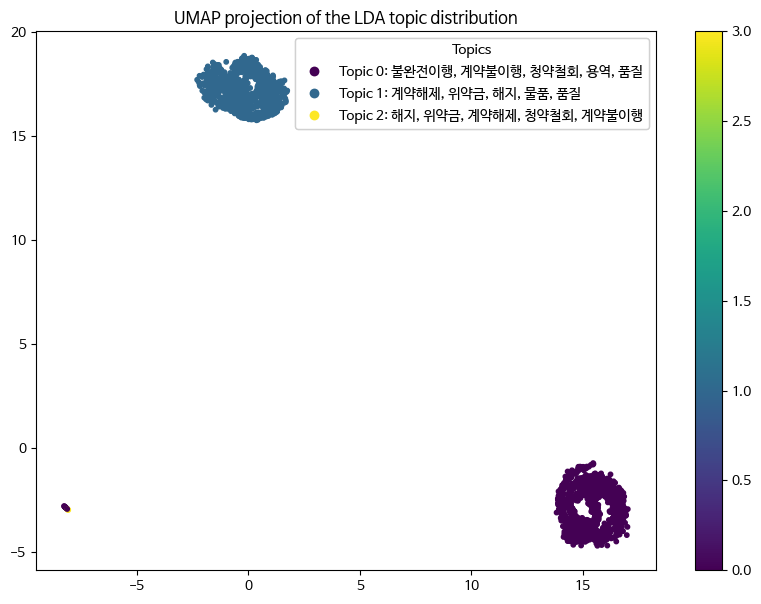

In [15]:
!pip install umap-learn
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 데이터프레임에서 '레몬트리'를 포함하는 행만 선택
lemon_tree_df = cleaned_df[cleaned_df['사건제목(ACCIDENT_TITLE)'].str.contains('레몬트리')]

# 상담이유명을 문자열로 변환
documents = lemon_tree_df['상담이유명(DSCSN_REASON_NAME)'].astype(str).tolist()

# 토큰화 및 벡터화
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X = vectorizer.fit_transform(documents)

# 호환성 문제를 해결하기 위한 코드 추가
vectorizer.get_feature_names = vectorizer.get_feature_names_out

# LDA 모델 훈련
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)  # 토픽 수를 4로 조정
lda_model.fit(X)

# LDA 모델을 사용하여 문서들의 토픽 분포를 얻습니다.
doc_topic_dists = lda_model.transform(X)

# 토픽별 주요 단어를 추출하는 함수
def display_topics(model, feature_names, no_top_words=5):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        keywords = np.array(feature_names)[np.argsort(topic)[::-1][:no_top_words]]
        topic_keywords[topic_idx] = keywords
    return topic_keywords

topic_keywords = display_topics(lda_model, vectorizer.get_feature_names())

# 토픽들을 출력
for topic_idx, keywords in topic_keywords.items():
    print(f"토픽 {topic_idx + 1}: {', '.join(keywords)}")

# UMAP을 사용하여 토픽 분포를 2차원으로 줄입니다. UMAP의 매개변수를 조정하여 시각화 결과를 변화시킬 수 있습니다.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', n_components=2)  # n_neighbors, min_dist, n_components 수정 가능
embedding = reducer.fit_transform(doc_topic_dists)

# UMAP 시각화
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
            c=doc_topic_dists.argmax(axis=1), cmap='viridis', s=10)

# 레전드(legend)에 토픽별 주요 단어 추가
legend_labels = ["Topic {}: {}".format(topic, ", ".join(words)) for topic, words in topic_keywords.items()]
legend1 = plt.legend(handles=scatter.legend_elements()[0], title="Topics", labels=legend_labels)
plt.gca().add_artist(legend1)

plt.colorbar()
plt.title('UMAP projection of the LDA topic distribution')
plt.show()


In [16]:
# 데이터 샘플 확인
print(merged_df.head())

  사건번호(ACCIDENT_NO) 접수일자(RCPT_YMD)_x  성별코드(GENDER_CODE)_x 성별(GENDER)_x  \
0      2020-0000005       2020-01-01                  2.0           여성   
1      2020-0000003       2020-01-01                  1.0           남성   
2      2020-0000009       2020-01-01                  2.0           여성   
3      2020-0000073       2020-01-01                  1.0           남성   
4      2020-0000075       2020-01-01                  1.0           남성   

   연령대코드(AGE_GROUP_CODE)_x 연령대명(AGE_GROUP_NAME)_x  지역코드(AREA_CODE)_x  \
0                      5.0               40 - 49세               1403   
1                      4.0               30 - 39세                808   
2                      3.0               20 - 29세                812   
3                      5.0               40 - 49세                805   
4                      5.0               40 - 49세                805   

  지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  품목명(ITEM_NAME)  \
0              구미시           350104       항공여객운송서비스   
1           


# **쉬어가기) 어느 컬럼이 중요한가? **

1)'사건번호(ACCIDENT_NO)':
고유한 식별자로 사용 가능합니다.

2)'접수일자(RCPT_YMD)_x':
상담 데이터의 접수일자 정보입니다.

3)'성별(GENDER)_x':
고객의 성별 정보로, 고객 특성 분류에 활용할 수 있습니다.

4)'연령대코드(AGE_GROUP_CODE)_x':
고객의 연령대 정보로, 고객 특성 분류와 행동 예측에 활용 가능합니다.

5)'품목명(ITEM_NAME)':
상담의 대상이 된 제품 또는 서비스의 정보로,
행동 예측에 활용할 수 있습니다.

6)'사건제목(ACCIDENT_TITLE)':
상담 내용의 제목 또는 간략한 설명으로,
텍스트 분석 및 감정 분석에 활용 가능합니다.

7)'상담이유명(DSCSN_REASON_NAME)':
상담의 주요 이유를 나타내는 텍스트 정보로,
텍스트 분석 및 감정 분석에 활용 가능합니다.

# 중간 보고 )

1) 사건번호, 접수일자, 성별, 연령대, 품목명, 사건제목, 상담이유명은 피처 엔지니어링으로 활용할지 고민합니다.
2) 사건 제목과 상담이유명으로 텍스트 분석 및 감정 분석 수행합니다.


# **4. 데이터 전처리 상세**

In [17]:
# 성별(GENDER)_x 컬럼에서 여성 데이터 확인
print(merged_df['성별(GENDER)_x'].unique())

# 성별(GENDER)_y 컬럼에서 여성 데이터 확인
print(merged_df['성별(GENDER)_y'].unique())


['여성' '남성' nan]
['여성' '남성' nan]


In [18]:
# 데이터프레임의 컬럼 목록 출력
print(merged_df.columns)


Index(['사건번호(ACCIDENT_NO)', '접수일자(RCPT_YMD)_x', '성별코드(GENDER_CODE)_x',
       '성별(GENDER)_x', '연령대코드(AGE_GROUP_CODE)_x', '연령대명(AGE_GROUP_NAME)_x',
       '지역코드(AREA_CODE)_x', '지역명(AREA_NAME)_x', '품목코드(ITEM_CODE)',
       '품목명(ITEM_NAME)', '사건제목(ACCIDENT_TITLE)', '상담이유코드(DSCSN_REASON_CODE)',
       '상담이유명(DSCSN_REASON_NAME)', '접수일자(RCPT_YMD)_y', '성별코드(GENDER_CODE)_y',
       '성별(GENDER)_y', '연령대코드(AGE_GROUP_CODE)_y', '연령대명(AGE_GROUP_NAME)_y',
       '지역코드(AREA_CODE)_y', '지역명(AREA_NAME)_y'],
      dtype='object')


In [19]:
# 필요한 컬럼 선택
selected_columns = [
    '상담이유명(DSCSN_REASON_NAME)',
    '성별(GENDER)_x',
    '연령대코드(AGE_GROUP_CODE)_x',
    '지역명(AREA_NAME)_x',
    '품목코드(ITEM_CODE)',
    '품목명(ITEM_NAME)'
    '사건제목(ACCIDENT_TITLE)'
]

data = merged_df[selected_columns]

In [20]:
data[selected_columns].head()


상담이유명(DSCSN_REASON_NAME) 성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  \
0             계약불이행(불완전이행)           여성                      5.0   
1                품질(물품/용역)           남성                      4.0   
2             계약불이행(불완전이행)           여성                      3.0   
3             계약불이행(불완전이행)           남성                      5.0   
4             계약불이행(불완전이행)           남성                      5.0   

  지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  
0              구미시           350104  
1              부천시           410403  
2              안산시           230399  
3              군포시           370499  
4              군포시           500704

In [21]:
# 데이터 타입 확인
data.dtypes

상담이유명(DSCSN_REASON_NAME)     object
성별(GENDER)_x                 object
연령대코드(AGE_GROUP_CODE)_x     float64
지역명(AREA_NAME)_x             object
품목코드(ITEM_CODE)               int64
dtype: object

In [22]:
# '재상담 여부' 라벨 생성 (예를 들어, '재상담'을 예측하는 경우)
data['재상담 여부'] = np.where(data['상담이유명(DSCSN_REASON_NAME)'] == '재상담', 1, 0)

<ipython-input-22-fdb6bd0ba30b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['재상담 여부'] = np.where(data['상담이유명(DSCSN_REASON_NAME)'] == '재상담', 1, 0)


In [23]:
# 숫자로 변환할 수 없는 컬럼 삭제
data = data.drop(columns=['상담이유명(DSCSN_REASON_NAME)'])

In [24]:
# 데이터 타입 확인
data.dtypes


성별(GENDER)_x                object
연령대코드(AGE_GROUP_CODE)_x    float64
지역명(AREA_NAME)_x            object
품목코드(ITEM_CODE)              int64
재상담 여부                       int64
dtype: object

In [25]:
data.head()

성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x 지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  \
0           여성                      5.0              구미시           350104   
1           남성                      4.0              부천시           410403   
2           여성                      3.0              안산시           230399   
3           남성                      5.0              군포시           370499   
4           남성                      5.0              군포시           500704   

   재상담 여부  
0       0  
1       0  
2       0  
3       0  
4       0

In [26]:
# 각 컬럼별 결측치 개수 확인
missing_values = data[['성별(GENDER)_x', '연령대코드(AGE_GROUP_CODE)_x', '지역명(AREA_NAME)_x', '품목코드(ITEM_CODE)', '재상담 여부']].isna().sum()

print(missing_values)

성별(GENDER)_x               1348
연령대코드(AGE_GROUP_CODE)_x       0
지역명(AREA_NAME)_x              0
품목코드(ITEM_CODE)               0
재상담 여부                        0
dtype: int64


In [27]:
data['성별(GENDER)_x'].fillna('기타', inplace=True)
data['성별(GENDER)_x'] = data['성별(GENDER)_x'].map({'여성': 0, '남성': 1, '기타': 2})

In [28]:
data['연령대코드(AGE_GROUP_CODE)_x'] = data['연령대코드(AGE_GROUP_CODE)_x'].astype(int)

In [29]:
data['지역명(AREA_NAME)_x'], _ = pd.factorize(data['지역명(AREA_NAME)_x'])

In [30]:
# 데이터 타입 확인
data.dtypes

성별(GENDER)_x               int64
연령대코드(AGE_GROUP_CODE)_x    int64
지역명(AREA_NAME)_x           int64
품목코드(ITEM_CODE)            int64
재상담 여부                     int64
dtype: object

In [31]:
X = data.drop('재상담 여부', axis=1)
y = data['재상담 여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
X = data.drop('재상담 여부', axis=1)
y = data['재상담 여부']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
print(data.isnull().sum())


성별(GENDER)_x               0
연령대코드(AGE_GROUP_CODE)_x    0
지역명(AREA_NAME)_x           0
품목코드(ITEM_CODE)            0
재상담 여부                     0
dtype: int64


In [34]:
print(data.describe())


       성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  지역명(AREA_NAME)_x  \
count  44563.000000             44563.000000      44563.000000   
mean       0.475192                 5.285730         50.449117   
std        0.556678                 2.099489         46.415726   
min        0.000000                 1.000000          0.000000   
25%        0.000000                 4.000000         11.000000   
50%        0.000000                 5.000000         36.000000   
75%        1.000000                 6.000000         76.000000   
max        2.000000                12.000000        235.000000   

       품목코드(ITEM_CODE)   재상담 여부  
count     44563.000000  44563.0  
mean     278896.418217      0.0  
std      121037.549850      0.0  
min      110101.000000      0.0  
25%      170399.000000      0.0  
50%      240603.000000      0.0  
75%      370102.000000      0.0  
max      510399.000000      0.0  


In [35]:
print(data['재상담 여부'].value_counts())


재상담 여부
0    44563
Name: count, dtype: int64


In [36]:
data = data.drop_duplicates()


In [37]:
print(data.corr())


                         성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  \
성별(GENDER)_x                 1.000000                 0.037801   
연령대코드(AGE_GROUP_CODE)_x      0.037801                 1.000000   
지역명(AREA_NAME)_x             0.010655                 0.011840   
품목코드(ITEM_CODE)             -0.003345                -0.009224   
재상담 여부                            NaN                      NaN   

                         지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  재상담 여부  
성별(GENDER)_x                     0.010655        -0.003345     NaN  
연령대코드(AGE_GROUP_CODE)_x          0.011840        -0.009224     NaN  
지역명(AREA_NAME)_x                 1.000000        -0.001050     NaN  
품목코드(ITEM_CODE)                 -0.001050         1.000000     NaN  
재상담 여부                                NaN              NaN     NaN  


In [38]:
# 1. 성별(GENDER)_x 값 수정
# 성별 값이 2인 행을 제거합니다.
data = data[data['성별(GENDER)_x'] != 2]

# 2. 지역명(AREA_NAME)_x 범위 확인
print("지역명(AREA_NAME)_x 최소값:", data['지역명(AREA_NAME)_x'].min())
print("지역명(AREA_NAME)_x 최대값:", data['지역명(AREA_NAME)_x'].max())




지역명(AREA_NAME)_x 최소값: 0
지역명(AREA_NAME)_x 최대값: 235


In [39]:
# 지역명(AREA_NAME)_x의 값 분포를 확인
print(data['지역명(AREA_NAME)_x'].value_counts())


지역명(AREA_NAME)_x
8      2224
27     1163
36      929
25      696
6       599
       ... 
210       3
233       3
231       2
225       1
235       1
Name: count, Length: 236, dtype: int64


In [40]:
# 서울특별시에 해당하는 데이터만 필터링
seoul_data = data[data['지역명(AREA_NAME)_x'] == 100]

# 필터링된 데이터 확인
print(seoul_data.head())
print(seoul_data.shape)

      성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  지역명(AREA_NAME)_x  \
328              0                        4               100   
906              1                        6               100   
1727             0                        4               100   
1798             1                        5               100   
2370             0                        5               100   

      품목코드(ITEM_CODE)  재상담 여부  
328            210203       0  
906            370102       0  
1727           111399       0  
1798           490103       0  
2370           370102       0  
(63, 5)


In [41]:
print(data.corr())

                         성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  \
성별(GENDER)_x                 1.000000                 0.092871   
연령대코드(AGE_GROUP_CODE)_x      0.092871                 1.000000   
지역명(AREA_NAME)_x             0.000900                 0.012443   
품목코드(ITEM_CODE)              0.070087                -0.018877   
재상담 여부                            NaN                      NaN   

                         지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  재상담 여부  
성별(GENDER)_x                     0.000900         0.070087     NaN  
연령대코드(AGE_GROUP_CODE)_x          0.012443        -0.018877     NaN  
지역명(AREA_NAME)_x                 1.000000         0.001922     NaN  
품목코드(ITEM_CODE)                  0.001922         1.000000     NaN  
재상담 여부                                NaN              NaN     NaN  


# **4.1. 재전처리 및 EDA : 목표 타켓(y)값을 재상담여부에서 품목코드로 변경(재전처리)**

In [42]:
# 재상담 여부 컬럼 삭제
data = data.drop(columns=['재상담 여부'])

# 품목코드별 데이터 빈도수 확인
item_counts = data['품목코드(ITEM_CODE)'].value_counts()

print(item_counts)


품목코드(ITEM_CODE)
350104    782
360302    735
370102    626
299999    536
499993    517
         ... 
170701      1
210217      1
230303      1
111209      1
111333      1
Name: count, Length: 1022, dtype: int64


In [43]:
# 품목코드별 데이터 빈도수 확인
top_10_items = data['품목코드(ITEM_CODE)'].value_counts().head(10).index

print("상위 10개 품목코드:")
print(top_10_items)


상위 10개 품목코드:
Index([350104, 360302, 370102, 299999, 499993, 360701, 370408, 189999, 170207,
       139912],
      dtype='int64', name='품목코드(ITEM_CODE)')


In [44]:
# 상위 10개 품목코드에 대한 성별 분포
top_10_gender_distribution = data[data['품목코드(ITEM_CODE)'].isin(top_10_items)].groupby('품목코드(ITEM_CODE)')['성별(GENDER)_x'].value_counts().unstack().fillna(0)
print("\n상위 10개 품목코드의 성별 분포:")
print(top_10_gender_distribution)

# 상위 10개 품목코드에 대한 연령대 분포
top_10_age_distribution = data[data['품목코드(ITEM_CODE)'].isin(top_10_items)].groupby('품목코드(ITEM_CODE)')['연령대코드(AGE_GROUP_CODE)_x'].value_counts().unstack().fillna(0)
print("\n상위 10개 품목코드의 연령대 분포:")
print(top_10_age_distribution)



상위 10개 품목코드의 성별 분포:
성별(GENDER)_x       0    1
품목코드(ITEM_CODE)          
139912           230  197
170207           385   55
189999           252  191
299999           285  251
350104           380  402
360302           297  438
360701           200  278
370102           346  280
370408           275  185
499993           251  266

상위 10개 품목코드의 연령대 분포:
연령대코드(AGE_GROUP_CODE)_x   1    2      3      4      5      6     8     9   \
품목코드(ITEM_CODE)                                                             
139912                   1.0  0.0   20.0  111.0  130.0  105.0   9.0   3.0   
170207                   0.0  0.0   30.0   98.0  128.0  132.0   4.0   0.0   
189999                   0.0  2.0   58.0  136.0  111.0   74.0  12.0   8.0   
299999                   1.0  1.0   50.0  110.0  152.0  119.0  12.0  12.0   
350104                   1.0  3.0  186.0  237.0  195.0  106.0   5.0   0.0   
360302                   0.0  3.0  123.0  164.0  181.0  133.0  35.0   4.0   
360701                   0.0 

In [45]:
print(data.corr())

                         성별(GENDER)_x  연령대코드(AGE_GROUP_CODE)_x  \
성별(GENDER)_x                 1.000000                 0.092871   
연령대코드(AGE_GROUP_CODE)_x      0.092871                 1.000000   
지역명(AREA_NAME)_x             0.000900                 0.012443   
품목코드(ITEM_CODE)              0.070087                -0.018877   

                         지역명(AREA_NAME)_x  품목코드(ITEM_CODE)  
성별(GENDER)_x                     0.000900         0.070087  
연령대코드(AGE_GROUP_CODE)_x          0.012443        -0.018877  
지역명(AREA_NAME)_x                 1.000000         0.001922  
품목코드(ITEM_CODE)                  0.001922         1.000000  


해석) 상관계수 행렬 분석
성별(GENDER)_x와 연령대코드(AGE_GROUP_CODE)_x:

상관계수 값은 약 0.093으로 양의 상관관계가 있지만, 이 값은 매우 낮기 때문에 두 변수 사이에는 큰 연관성이 없다고 볼 수 있습니다.
성별(GENDER)_x와 품목코드(ITEM_CODE):

상관계수 값은 약 0.0701로 양의 상관관계가 있지만, 이 값도 낮기 때문에 큰 연관성은 없다고 볼 수 있습니다.
연령대코드(AGE_GROUP_CODE)_x와 지역명(AREA_NAME)_x:

상관계수 값은 약 0.0124로 두 변수 사이에는 거의 연관성이 없다고 볼 수 있습니다.
연령대코드(AGE_GROUP_CODE)_x와 품목코드(ITEM_CODE):

상관계수 값은 약 -0.0189로 약한 음의 상관관계를 가지고 있습니다. 하지만 이 값도 낮기 때문에 큰 연관성은 없다고 볼 수 있습니다.
지역명(AREA_NAME)_x와 품목코드(ITEM_CODE):

상관계수 값은 약 0.0019로 거의 연관성이 없다고 볼 수 있습니다.


In [50]:
data.head()
data.tail()
data.shape
data.info()
data.describe()
data.columns
data.isna().sum()
data.dtypes
# 컬럼명 조회
column_names = data.columns
print(column_names)

<class 'pandas.core.frame.DataFrame'>
Index: 27937 entries, 0 to 44561
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   성별(GENDER)_x             27937 non-null  int64
 1   연령대코드(AGE_GROUP_CODE)_x  27937 non-null  int64
 2   지역명(AREA_NAME)_x         27937 non-null  int64
 3   품목코드(ITEM_CODE)          27937 non-null  int64
dtypes: int64(4)
memory usage: 1.1 MB
Index(['성별(GENDER)_x', '연령대코드(AGE_GROUP_CODE)_x', '지역명(AREA_NAME)_x',
       '품목코드(ITEM_CODE)'],
      dtype='object')


피쳐엔지니어링

품목 코드의 의미: 품목 코드가 어떤 정보를 나타내는지 이해하는 것이 중요합니다. 품목 코드가 서로 다른 특성을 가지고 있다면 클러스터링이 의미 있을 수 있습니다. 예를 들어, 품목 코드가 제품 카테고리를 나타낸다면, 유사한 카테고리의 제품을 클러스터링할 수 있습니다.

클러스터링 알고리즘 선택: 클러스터링을 수행하기 위해 어떤 클러스터링 알고리즘을 사용할 것인지 결정해야 합니다. 대표적인 클러스터링 알고리즘으로는 K-평균 클러스터링, 계층적 클러스터링, DBSCAN 등이 있습니다.

클러스터 수 결정: 클러스터 수를 얼마나 설정할 것인지 결정해야 합니다. 이것은 클러스터링 알고리즘에 따라 다르며, 적절한 클러스터 수를 찾는 데 여러 방법이 있습니다.

새로운 특성 생성: 클러스터링을 통해 각 데이터 포인트에 클러스터 ID를 할당한 후, 이 클러스터 ID를 새로운 특성으로 추가합니다. 이렇게 하면 각 데이터 포인트가 어떤 클러스터에 속하는지를 모델에 제공할 수 있습니다.

모델 학습: 클러스터 ID를 새로운 특성으로 추가한 후, 모델을 학습시키고 성능을 평가합니다. 클러스터 ID를 특성으로 사용하면 해당 클러스터에 대한 정보를 모델이 활용할 수 있습니다.

In [67]:
from sklearn.metrics import f1_score

# 실제 타겟과 모델의 예측을 가지고 있는 배열을 사용합니다.
y_true = [0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1]

# F1 스코어 계산
f1 = f1_score(y_true, y_pred)

print("F1 스코어:", f1)


F1 스코어: 0.8571428571428571


# **5.모델 예측 및 평가**

과적합 문제:

파악 방법: 모델을 학습할 때 학습 데이터와 검증 데이터의 성능을 모니터링합니다. 모델이 학습 데이터에 과적합되면 검증 데이터에서 성능이 저하됩니다.
해결 방법: 모델 복잡도를 줄이기 위해 하이퍼파라미터 조정, 교차 검증, 조기 종료(early stopping) 등을 고려합니다.

In [63]:
# 모델 정보 확인
print(rf_model)

RandomForestClassifier(random_state=42)


In [65]:
# 랜덤 포레스트 모델 초기화 (랜덤성 고정)
rf_model = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100],    # 트리 개수
    'max_depth': [None, 10],      # 트리 최대 깊이
    'min_samples_split': [2, 5],  # 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2]    # 리프 노드 최소 샘플 수
}

# 그리드 서치를 통한 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터로 모델 초기화
best_rf_model = grid_search.best_estimator_

# 모델 학습 (랜덤성 고정)
best_rf_model.fit(X_train, y_train)

# 교차 검증을 통한 모델 성능 확인
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# 조기 종료를 적용한 랜덤 포레스트
best_rf_model.fit(X_train, y_train)

# 검증 데이터로 예측
y_val_pred = best_rf_model.predict(X_val)

# 모델 성능 평가 (예: 정확도)
accuracy = accuracy_score(y_val, y_val_pred)
print("검증 데이터 정확도:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0
검증 데이터 정확도: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

In [66]:
# 학습된 랜덤 포레스트 모델에서 특성 중요도를 가져옵니다.
feature_importances = best_rf_model.feature_importances_

# 특성 중요도를 출력합니다.
print("특성 중요도:", feature_importances)


특성 중요도: [0. 0. 0. 0.]


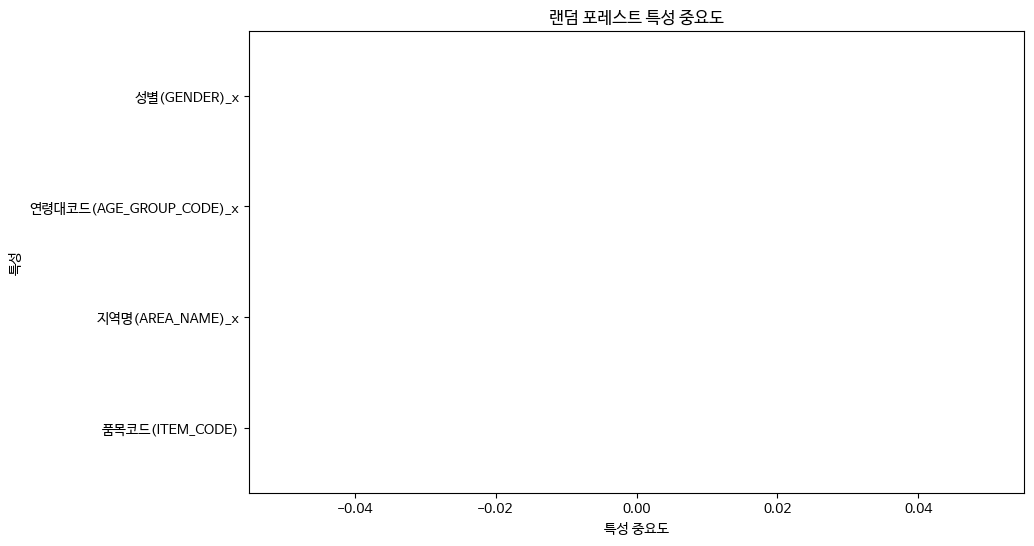

In [58]:
# 특성 중요도를 기준으로 내림차순 정렬합니다.
sorted_indices = np.argsort(feature_importances)[::-1]

# 중요도가 높은 상위 n개의 특성을 선택합니다.
top_n = 5
top_features = sorted_indices[:top_n]
top_feature_names = [X.columns[i] for i in top_features]

# 특성 중요도 시각화 (모든 특성)
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), X.columns)
plt.xlabel('특성 중요도')
plt.ylabel('특성')
plt.title('랜덤 포레스트 특성 중요도')
plt.gca().invert_yaxis()
plt.show()





